In [1]:
using HDF5, PyPlot, Glob, CSV, DataFrames, Dates, Distributions, GLM, StatsBase, MAT, NaNStatistics

In [2]:
drv = "/mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/"
outpath = drv*"output/"
motion_file = drv*"motion/motion_regression_1s_ISI.mat"
file_list = glob("*mat",drv)
fps = 4
colors=[[241, 106, 5],[82, 121, 111],[165, 0, 43],[79, 53, 155],[55,151,113],[191,124,25],[54,118,152]]./255

nsa = .002
ymn,ymx=200,1300
xmn,xmx=0,600

(0, 600)

In [3]:
#1 ISI 
pnum = 3
snum = 7
isi = 1*fps

4

In [4]:
pipeline_output = h5open(file_list[pnum],"r")
keys(pipeline_output)

6-element Vector{String}:
 "#refs#"
 "DF"
 "ROI_centroids"
 "fish_ncells"
 "fish_numbers"
 "idx_fish"

In [5]:
centroids = pipeline_output["ROI_centroids"][]
idx_fish = pipeline_output["idx_fish"][]
file = matopen(file_list[snum],"r")
motion = matopen(motion_file,"r")
motion_reg = read(motion,"motion_regressor")
motion_corr = read(motion,"motion_correct")
keys(file)

KeySet for a Dict{String, Int64} with 4 entries. Keys:
  "framerate"
  "stimtimes"
  "stim_seq"
  "stim_freqs"

In [6]:
framerate = read(file,"framerate")
stimtimes = read(file,"stimtimes")
stimtimes = Int.(stimtimes)
stim_seq = vec(read(file,"stim_seq"))
stim_freqs = vec(read(file,"stim_freqs"))
stimtimes[61:end] .-= 1
IJulia.clear_output()

0

In [7]:
DF = pipeline_output["DF"][]
total_rois = length(DF[:,1])
IJulia.clear_output()

0

In [8]:
n_frames = length(DF[1,:])
total_rois = length(DF[:,1])
spike=[0,1.69644104899772,5.13796058542217,8.27886020152244,10.3756715204800,11.8173714529814,12.2425184714093,10.8571417354877,8.80831829681196,6.91339112244670,5.46959264663869,4.30868766622567,3.42533619066766,2.75378443486879,2.18017250852183,1.72816235135824,1.32732537295463,1.00684435500268,0.730210038304555,0.530242444093118,0.362253250339685,0.227668255288566,0.0869242416152502,0.000718266708050853,-0.0828334873368325]';
spike = vec(spike./maximum(spike))

25-element Vector{Float64}:
  0.0
  0.13856961318535252
  0.41968166904719506
  0.6762383263587934
  0.8475111999798847
  0.9652729118260452
  1.0
  0.8868389098895824
  0.71948580820054
  0.5647033442172837
  0.446770218024352
  0.35194455097519445
  0.27979015908099764
  0.22493610618598375
  0.17808202728983583
  0.14116068972198187
  0.10841930735529735
  0.08224160391132143
  0.05964541037939694
  0.043311549443966584
  0.02958976547069764
  0.0185965212811607
  0.007100192809040859
  5.866984883284147e-5
 -0.006766049610648217

### Detect block edges and stimulus times

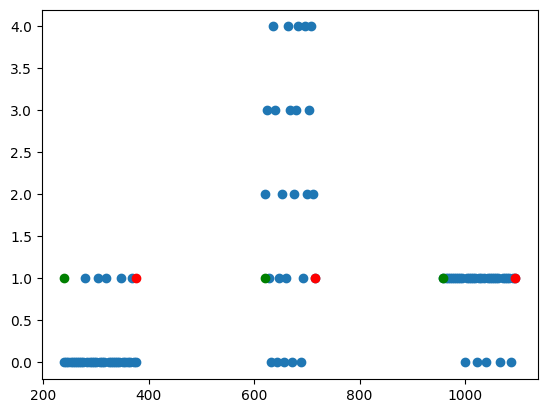

10-element Vector{Int64}:
  328
  336
  352
  360
  376
 1031
 1047
 1063
 1079
 1095

In [74]:
scatter(stimtimes,stim_seq)

block_edges = Array{Int64}(undef,3,2)
b_ctr = 1
block_edges[1,1] = stimtimes[1]
block_edges[3,2] = stimtimes[end]
flag = 0
for s = 2:length(stimtimes)-1
    isi_now = stimtimes[s+1]-stimtimes[s]
    if isi_now > 6
        #print(isi_now)
        block_edges[b_ctr,2] = stimtimes[s]
        b_ctr+=1
        flag = 1
    end
    if flag == 1 && isi_now == isi
        block_edges[b_ctr,1] = stimtimes[s]
        flag = 0
    end
end

for b = 1:3
    scatter(block_edges[b,1],1,color="green")
    scatter(block_edges[b,2],1,color="red")
end

oddball_times = []
oddball_1st = []
oddball_2nd = []

for i = 1:35
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(oddball_times,stimtimes[i])
        append!(oddball_1st,stimtimes[i])
    end
end

for i = length(stimtimes)-35:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 0
        append!(oddball_times,stimtimes[i])
        append!(oddball_2nd,stimtimes[i])
    end
end

f1_times = []
f2_times = []
for i = 1:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(f1_times,stimtimes[i])
    end
end

ms_f1_times = []
ms_f2_times = []
ms_f3_times = []
ms_f4_times = []
ms_f5_times = []

for i = findall((stimtimes .>= block_edges[2,1]) .&& (stimtimes .<= block_edges[2,2]))
    curr_stim = stim_seq[i[2]]
    if curr_stim == 1
        append!(ms_f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(ms_f1_times,stimtimes[i])
    elseif curr_stim == 2
        append!(ms_f3_times,stimtimes[i])
    elseif curr_stim == 3
        append!(ms_f4_times,stimtimes[i])
    elseif curr_stim == 4
        append!(ms_f5_times,stimtimes[i])
    end
end

rng1 = Int(oddball_1st[1]):isi*2:Int(block_edges[1,2])
rng2 = Int(oddball_2nd[1]):isi*2:Int(block_edges[3,2])

randtimes = vcat(sort(sample(rng1,5,replace=false)),sort(sample(rng2,5,replace=false)))

r1 = collect(rng1)[5:end]
rn2 = collect(rng2)[5:end]
filter!(r1->r1∉oddball_1st,r1)
filter!(rn2->rn2∉oddball_2nd,rn2)

offset_1 = sort(sample(r1, 5, replace=false))
offset_2 = sort(sample(rn2,5,replace=false))
offset_all = vcat(offset_1,offset_2)



### Compute regressors

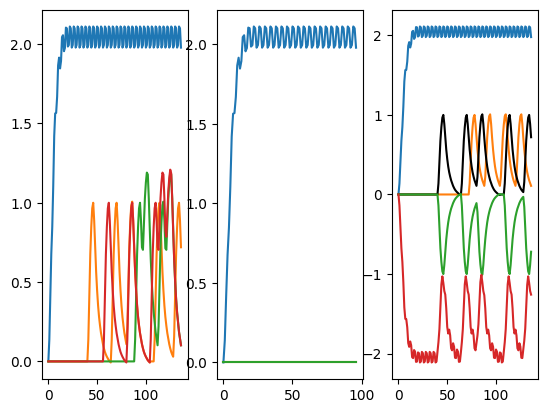

13-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"
 "ms_f1_reg"
 "ms_f2_reg"
 "enhanced_reg"

In [76]:
function compute_calcium(times)
    reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
    return reg
end

auditory_reg = compute_calcium(stimtimes)
oddball_reg = compute_calcium(oddball_times)
oddball_offset_reg = compute_calcium(offset_all)
random_reg = compute_calcium(randtimes)

f1_reg = compute_calcium(f1_times)
f2_reg = compute_calcium(f2_times)

ms_f1_reg = compute_calcium(ms_f1_times)
ms_f2_reg = compute_calcium(ms_f2_times)

ob1_reg = compute_calcium(oddball_1st)
ob2_reg = compute_calcium(oddball_2nd)

ob1_offset_reg = compute_calcium(offset_1)
ob2_offset_reg = compute_calcium(offset_2)

subplot(131)
rng = block_edges[1,1]:block_edges[1,2]
plot(auditory_reg[rng])
plot(oddball_reg[rng])
plot(oddball_offset_reg[rng])
plot(random_reg[rng])

subplot(132)
rng = block_edges[2,1]:block_edges[2,2]
plot(auditory_reg[rng])
plot(oddball_reg[rng])
plot(oddball_offset_reg[rng])

subplot(133)
rng = block_edges[3,1]:block_edges[3,2]
plot(auditory_reg[rng])
plot(oddball_offset_reg[rng])
plot(oddball_reg[rng],color="black")
plot(.-f1_reg[rng])
plot(.-f2_reg[rng])

enhanced_reg = auditory_reg .+ oddball_reg

exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg,ms_f1_reg,ms_f2_reg,enhanced_reg]#,motion_reg]
reg_titles = ["auditory","oddball","oddball_offset","random","freq1","freq2","ob_1st","ob_2nd","ob_1st_offset","ob_2nd_offset","ms_f1_reg","ms_f2_reg","enhanced_reg"]#,"motion"]

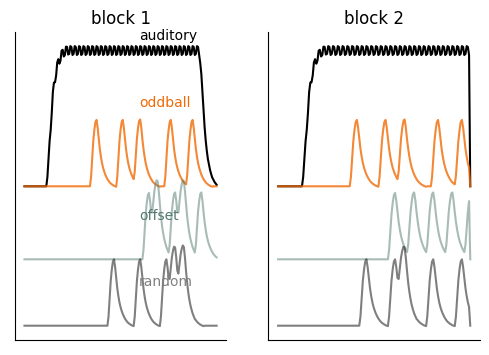

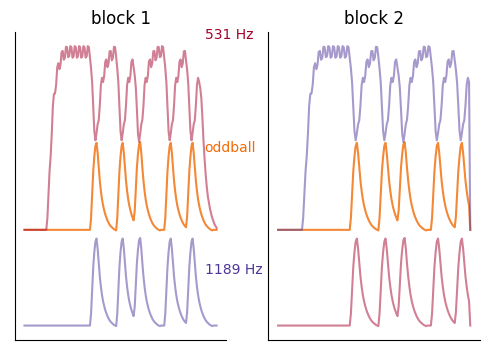

Any[]

In [78]:
figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 105
text(xpos,2.2,"auditory",color="black")
text(xpos,1.2,"oddball",color=colors[1])
text(xpos,-0.5,"offset",color=colors[2])
text(xpos,-1.5,"random",color="gray")

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
#plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f1_reg[rng],color=colors[3],alpha=0.5)
plot(f2_reg[rng].-1.1,color=colors[4],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 165
text(xpos,2.2,"531 Hz",color=colors[3])
text(xpos,0.9,"oddball",color=colors[1])
text(xpos,-0.5,"1189 Hz",color=colors[4])
#text(xpos,-1.5,"random",color=colors[4])

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f2_reg[rng],color=colors[4],alpha=0.5)
plot(f1_reg[rng].-1.1,color=colors[3],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

## Perform regressions

In [79]:
#for i =1:total_rois
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)

t = now()
print("starting $t ...")
for i = 1:total_rois
    reg_ctr = 1
    yr = DF[i,:]
    for r = 1:length(exp_regs)
        t = now()
        xr = exp_regs[r]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s[reg_ctr,i] = r2(ols)
        coeffs[reg_ctr,i] = coef(ols)[2]
        pvals[reg_ctr,i] = coeftable(ols).cols[4][2]
        reg_ctr +=1
    end
end
t = now()
print("...complete $t")

starting 2024-06-05T09:59:24.283 ......complete 2024-06-05T10:02:39.339

### Save data

In [80]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"
if isfile(outfile) rm(outfile) end
of = h5open(outfile,"w")

for r=1:length(exp_regs)
    create_group(of,reg_titles[r])
    of[reg_titles[r]]["reg"] = exp_regs[r]
    of[reg_titles[r]]["r2"] = r2s[r,:]
    of[reg_titles[r]]["coef"] = coeffs[r,:]
    of[reg_titles[r]]["pval"] = pvals[r,:]
end

close(of)

### Read in the existing regressed data

In [81]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"

of = h5open(outfile,"r")
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)

for r=1:length(exp_regs)
    exp_regs[r] = of[reg_titles[r]]["reg"][]
    r2s[r,:] .= of[reg_titles[r]]["r2"][]
    coeffs[r,:] .= of[reg_titles[r]]["coef"][]
    pvals[r,:] .= of[reg_titles[r]]["pval"][]
end
close(of)

### Detect significant ROIs (p < .001/total ROIs && R^2 > 99th percentile)

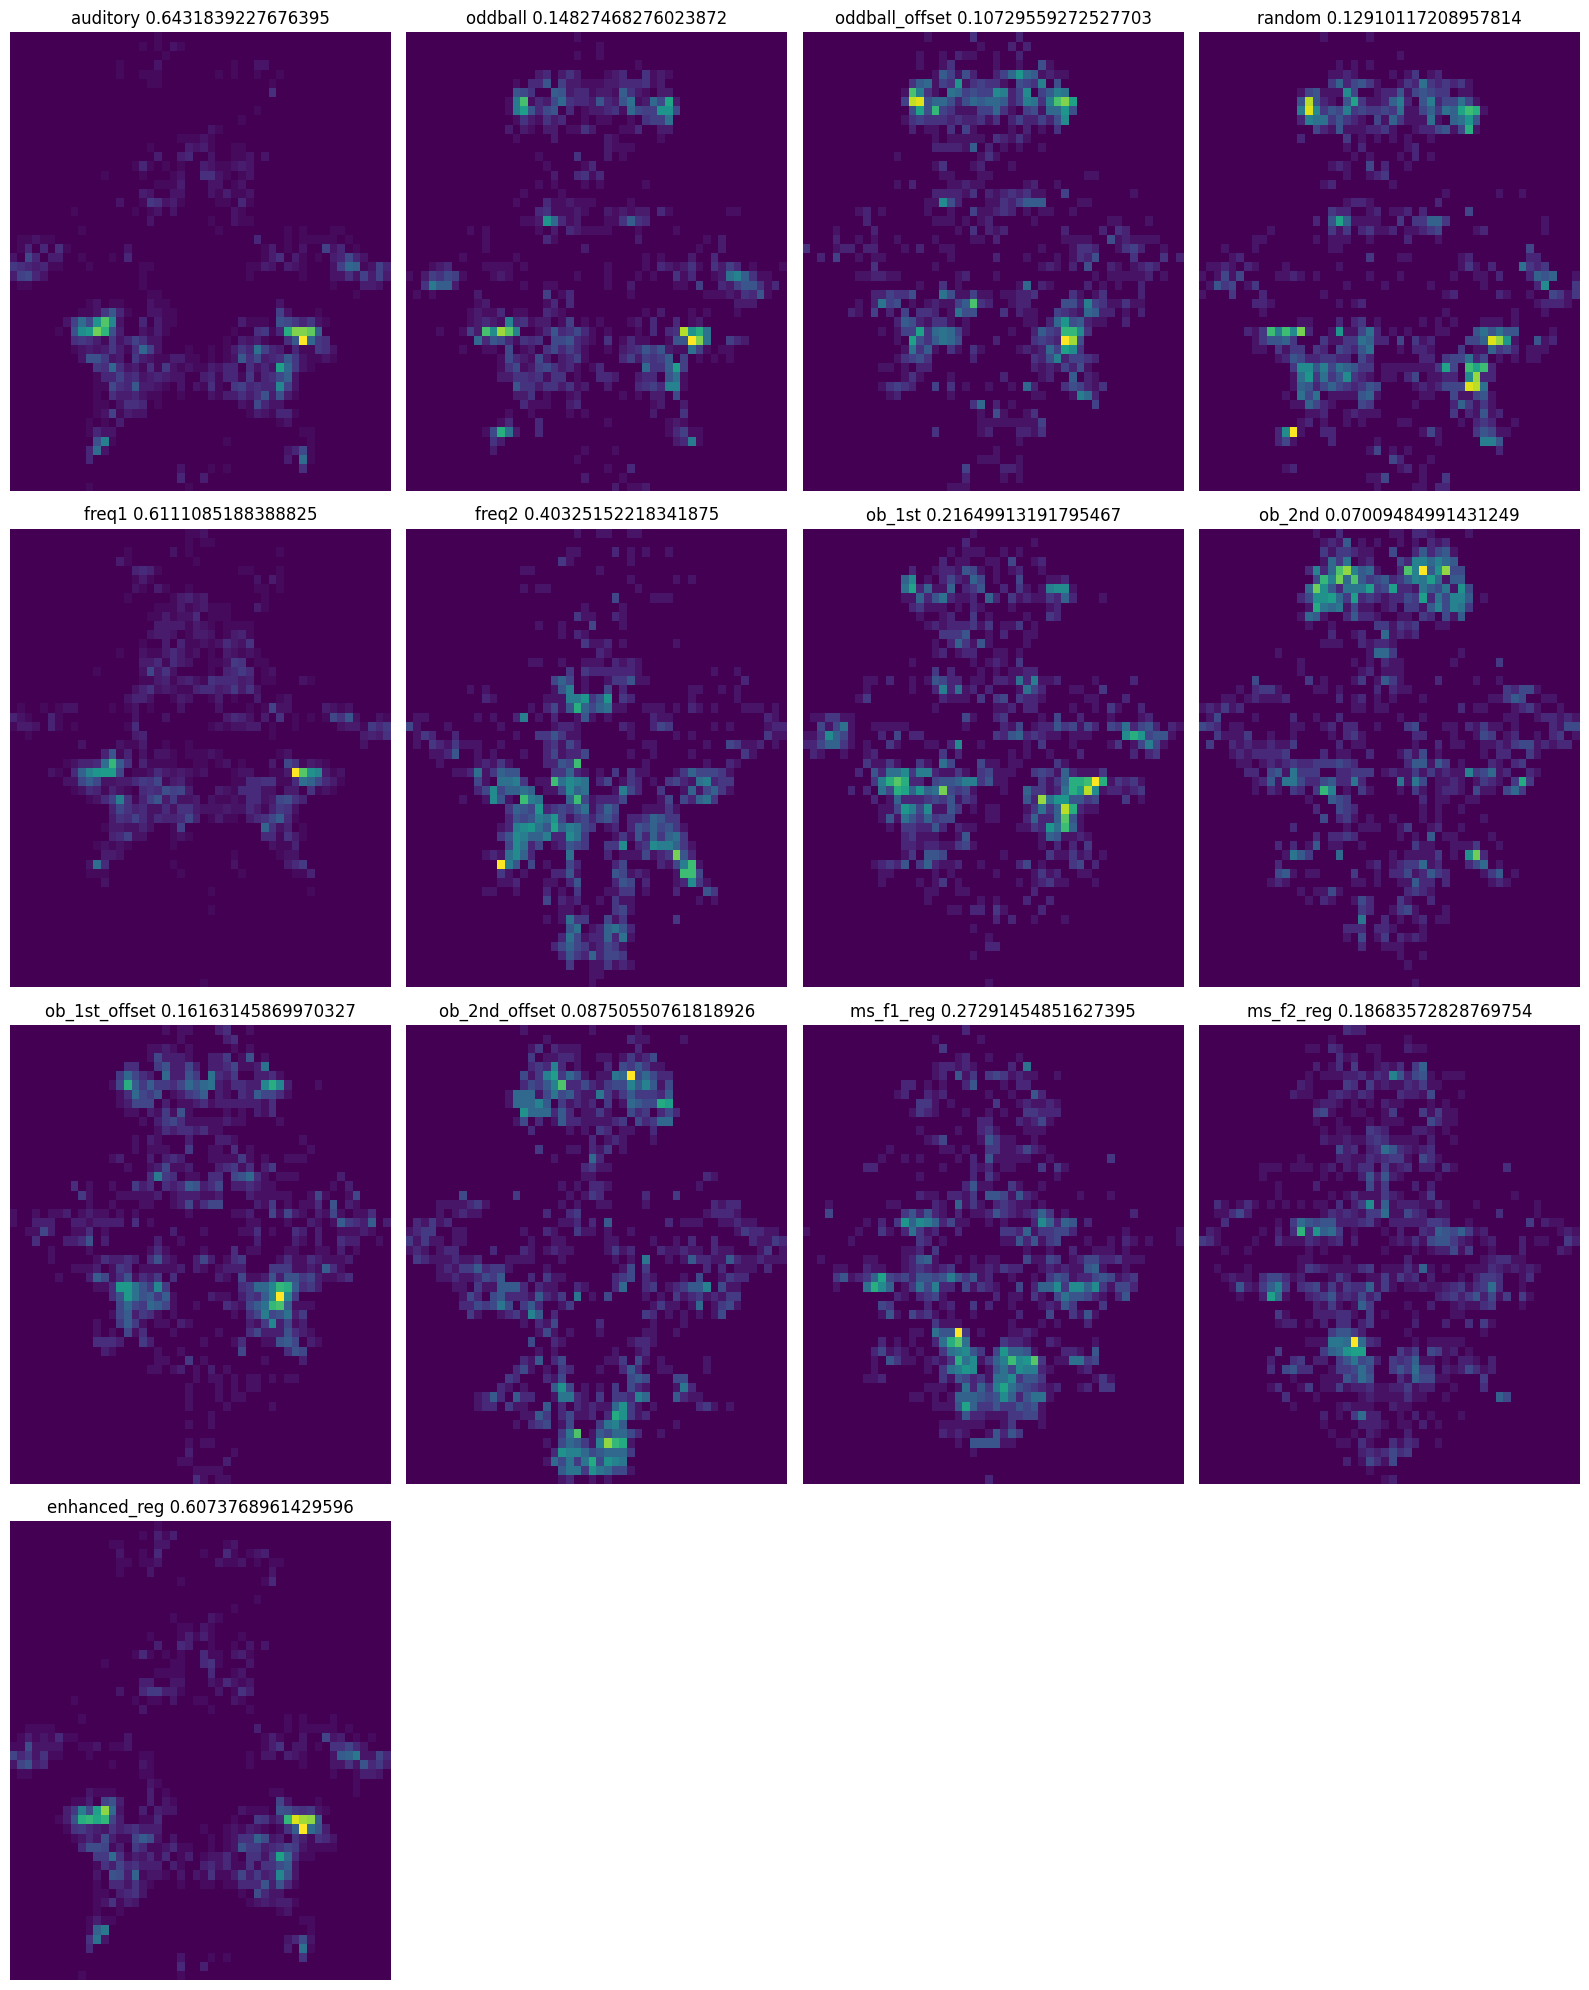

In [82]:
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

rows,cols=4,4
figure(figsize=(cols*4,rows*5)); 

alpha_cutoff = 0.001/total_rois
minimum_r2 = 0.0
maximum_r2 = 0.9
perc_cutoff = 99
reg_ctr = 1
for r=1:length(exp_regs)
    pvals_clean = pvals[r,:]
    sig_roi_pval = findall(pvals_clean .< alpha_cutoff);
    
    r2s_clean = replace(r2s[r,:],NaN=>0)
    perc_99 = percentile(r2s_clean,perc_cutoff)
    sig_roi_r2 = findall(r2s_clean .> perc_99);
    
    sig_roi = intersect(sig_roi_pval,sig_roi_r2)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sig_roi[1])

    push!(sig_rois,sig_roi)
    push!(nonsig_rois,nonsig_roi)
    subplot(rows,cols,r)
    title(reg_titles[r]*" $perc_99")
    plt.hist2d(centroids[sig_roi,2],centroids[sig_roi,1],bins=50); axis("off");
    reg_ctr += 1
end

tight_layout()

### Reset Fish index

In [39]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

In [40]:
n_fish = length(unique(idx_fish))

12

In [41]:
using PyCall
@pyimport matplotlib.colors as matcolors

cool_cmap = matcolors.LinearSegmentedColormap.from_list("cool", (
                 (0.000, (.996, .945, .894)),
                 (0.250, (0.914, 0.416, 0.165)),
                 (0.500, (0.605, 0.106, 0.784)),
                 (0.750, (0.04, 0.490, 0.486)),
                 (1.000, (0, 0, 0))))

@pyimport matplotlib.colors as matcolors

bwr_black = matcolors.LinearSegmentedColormap.from_list("bwr_black", (
                 (0.000, (0.298, 0.443, 1.000)),
                 (0.250, (0.000, 0.145, 0.702)),
                 (0.500, (0.000, 0.000, 0.000)),
                 (0.750, (0.780, 0.012, 0.051)),
                 (1.000, (0.988, 0.290, 0.325))))

In [43]:
n_fish = length(unique(idx_fish))
n_rois = length(DF[:,1])
n_frames = length(DF[1,:])
fs = 14

14

# Figure 1

## Figure 1E

In [46]:
sr = collect(1:n_rois)
avg = vec(mean(DF[sr,:],dims=1))
stdev = vec(std(DF[sr,:],dims=1))./n_fish
x = collect(1:n_frames)./fps

IJulia.clear_output()

0

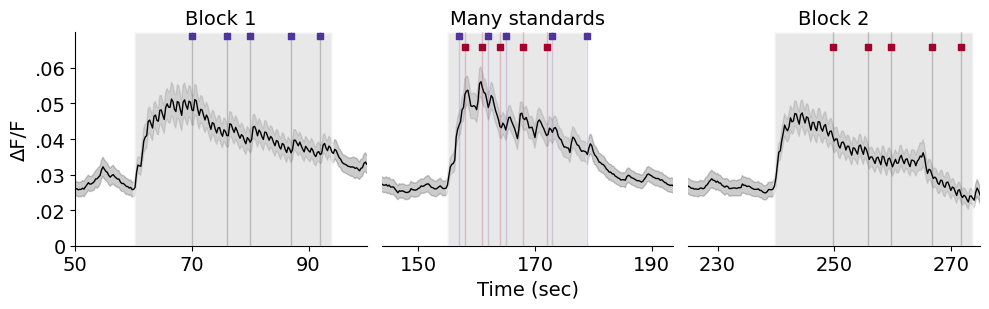

In [360]:
figure(figsize=(10,3.2))
ax1 = subplot(131); ax2 = subplot(132); ax3 = subplot(133)

yticks = [0,0.01,0.02,0.03,0.04,0.05]
ymax = 0.06
x = collect(1:n_frames)./fps
for t = 1:3
    axes = [ax1,ax2,ax3]
    subplot(1,3,t)
    fill_between(x, avg.-stdev, avg.+stdev,color="black",alpha=0.2)
    plot(x,avg,color="black",linewidth=1)
end

ax1.set_ylabel("ΔF/F",fontsize=fs)
ax1.set_yticks(yticks)
ax1.set_yticklabels(["0",".02",".03",".04",".05",".06"],fontsize=14)
ax1.set_xticks([50,70,90])
ax1.set_xlim(40,100)

ax2.set_xticks([150,170,190])
ax2.set_xlim(140,200)
ax2.set_xlabel("Time (sec)",fontsize=fs)
ax3.set_xticks([230,250,270])
ax3.set_xlim(220,280)

edge = block_edges[1,:]
ax1.axvspan(edge[1], edge[2], alpha=0.8, color="lightgray",lw=2,ec="white")
edge = block_edges[2,:]
ax2.axvspan(edge[1], edge[2], alpha=0.8, color="lightgray",lw=2,ec="white")
edge = block_edges[3,:]
ax3.axvspan(edge[1], edge[2], alpha=0.8, color="lightgray",lw=2,ec="white")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.06)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="x",labelsize=14)
    for t = 1:3
        edge = block_edges[t,:]
        ax.axvspan(edge[1]/fps, edge[2]/fps, alpha=0.5, color="lightgray",lw=2,ec="white")
    end
    for ob in oddball_times
        ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
    end

end

ob_size = 20 
ob_offset = 0.003

subplot(131); title("Block 1",fontsize=fs)
for ob in oddball_1st
    scatter(ob/fps,ymax-0.001,color=colors[4],marker="s",s=ob_size,zorder=3)
end

xlim(200/fps,400/fps)

subplot(132); title("Many standards",fontsize=fs)
for ob in ms_f1_times
    axvline(ob/fps,0,1,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-0.001-ob_offset,color=colors[3],marker="s",s=ob_size,zorder=3)
end

for ob in ms_f2_times
    axvline(ob/fps,0,1,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob/fps,ymax-0.001,color=colors[4],marker="s",s=ob_size,zorder=3)
end

xlim(575/fps,775/fps)
subplot(133); title("Block 2",fontsize=fs)

for ob in oddball_2nd
    scatter(ob/fps,ymax-0.001-ob_offset,color=colors[3],marker="s",s=ob_size,zorder=3)
end

xlim(900/fps,1100/fps)

for ax in [ax2,ax3]
    ax.spines["left"].set_visible(false)
    ax.set_yticks([])
    ax.set_yticks([], minor=true)
end

PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
tight_layout()

plt.savefig("figs/Fig1E.svg",dpi=600)

# Figure 2

## Figure 2A

In [327]:
ymn = 300
ymx = 1270
xmn = 0
xmx = 600

600

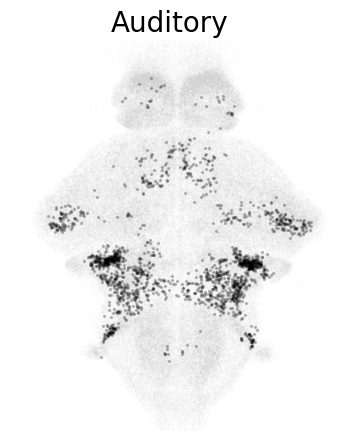

In [361]:
figure(figsize=(3.5,4.5)); 
a = 0.2

titles = ["Auditory","531 Hz","1189 Hz","Merge"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[13,:][1]

s = 2

ax1 = subplot(111); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color="black",s=s,alpha=a)

ctr = 1
for ax in [ax1]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=20)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2A.png",dpi=300)

## Figure 2B - SET AXES FUNCTION

In [47]:
function set_axes(ax1,ax2,ax3,yticks,yticklabels)
    ax1.set_ylabel("ΔF/F",fontsize=fs)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticklabels,fontsize=14)

    ### Axes limits
    ax1.set_xticks([60,70,80,90])
    ax1.set_xlim(50,100)
    ax2.set_xticks([150,160,170,180])
    ax2.set_xlim(140,190)
    ax2.set_xlabel("Time (sec)",fontsize=fs)
    ax3.set_xticks([240,250,260,270])
    ax3.set_xlim(230,280)

    edge = block_edges[1,:]
    ax1.axvspan(edge[1], edge[2], alpha=0.8, color="lightgray",lw=2,ec="white")
    edge = block_edges[2,:]
    ax2.axvspan(edge[1], edge[2], alpha=0.8, color="lightgray",lw=2,ec="white")
    edge = block_edges[3,:]
    ax3.axvspan(edge[1], edge[2], alpha=0.8, color="lightgray",lw=2,ec="white")

    subplot(131); title("Block 1",fontsize=fs)
    subplot(132); title("Many standards",fontsize=fs)
    subplot(133); title("Block 2",fontsize=fs)
    
    ctr = 1
    for ax in [ax1,ax2,ax3]
        ax.set_ylim(0,ymax)
        ax.spines["top"].set_visible(false)
        ax.spines["right"].set_visible(false)
        ax.tick_params(axis="x",labelsize=14)
        for t = 1:3
            edge = block_edges[t,:]
            ax.axvspan(edge[1]/fps, edge[2]/fps, alpha=0.5, color="lightgray",lw=2,ec="white")
        end


        for ob in oddball_1st
            ax.scatter(ob/fps,ymax-ob_offset,color=colors[4],marker="s",s=ob_size,zorder=3)
            ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
        end
        for ob in ms_f1_times
            ax.axvline(ob/fps,0,1,color=colors[3],linewidth=1,alpha=0.2)
            ax.scatter(ob/fps,ymax-ob_offset*3,color=colors[3],marker="s",s=ob_size,zorder=3)
        end

        for ob in ms_f2_times
            ax.axvline(ob/fps,0,1,color=colors[4],linewidth=1,alpha=0.2)
            ax.scatter(ob/fps,ymax-ob_offset,color=colors[4],marker="s",s=ob_size,zorder=3)
        end
        for ob in oddball_2nd
            ax.scatter(ob/fps,ymax-ob_offset*3,color=colors[3],marker="s",s=ob_size,zorder=3)
            ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)

        end
    end

    for ax in [ax2,ax3]
        ax.spines["left"].set_visible(false)
        ax.set_yticks([])
        ax.set_yticks([], minor=true)
    end
end

set_axes (generic function with 1 method)

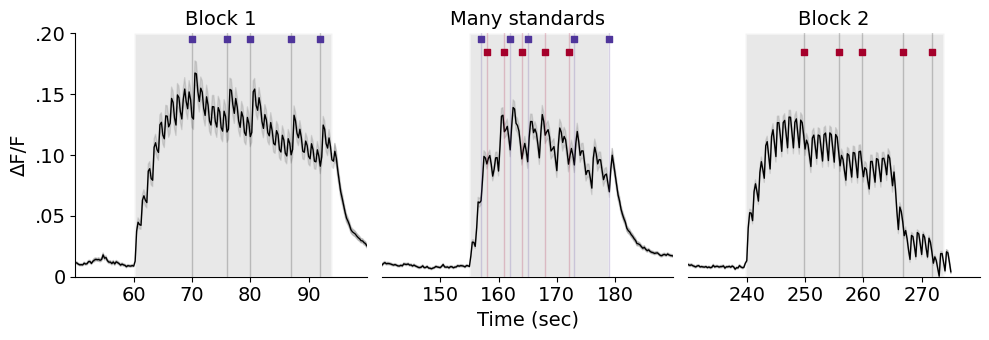

In [363]:
sr = sig_rois[1,:][1]
avg = vec(mean(DF[sr,:],dims=1))
stdev = vec(std(DF[sr,:],dims=1))./n_fish
x = collect(1:n_frames)./fps

IJulia.clear_output()

figure(figsize=(10,3.5))
ax1 = subplot(131); ax2 = subplot(132); ax3 = subplot(133)

ymax = 0.2
yticks = collect(0:0.05:ymax)

x = collect(1:n_frames)./fps
for t = 1:3
    axes = [ax1,ax2,ax3]
    subplot(1,3,t)
    fill_between(x, avg.-stdev, avg.+stdev,color="black",alpha=0.2)
    plot(x,avg,color="black",linewidth=1)
end

yticklabels = ["0",".05",".10",".15",".20"]
ob_size = 20 
ob_offset = 0.005
set_axes(ax1,ax2,ax3,yticks,yticklabels)


PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
tight_layout()

plt.savefig("figs/Fig2B.svg",dpi=300)

## Figure 2C

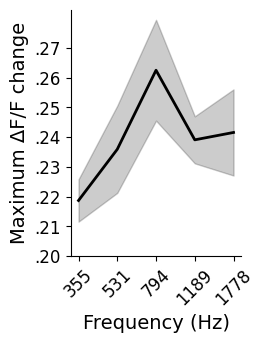

In [364]:
figure(figsize=(2.2,3.2))
ax = subplot(111)
col2 = ["black",colors[3],colors[4]]

r = 1
sr = sig_rois[1,:][1]
function max_df_change(sr,times)
    avg_all = []
    for stim in times
        y = DF[sr,stim:stim+isi-1]
        avg = maximum(y[2:end].-y[1])
        #if avg > 0 
        append!(avg_all,avg) 
        #else
        #    append!(avg_all,NaN)
        #end
    end
    return avg_all
end

totals = zeros((5))
errs = zeros((5,5))
all_resp = zeros((n_fish,5,5))
all_avgs = zeros((n_fish,5))
fish_ctr = 1
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[1,:][1]
    sr = intersect(sr,valid_idx)

    avg_f1 = max_df_change(sr,ms_f1_times)
    avg_f2 = max_df_change(sr,ms_f2_times)
    avg_f3 = max_df_change(sr,ms_f3_times)
    avg_f4 = max_df_change(sr,ms_f4_times)
    avg_f5 = max_df_change(sr,ms_f5_times)

    avgs_list = [avg_f3,avg_f1,avg_f4,avg_f2,avg_f5]
    for i = 1:5
        errs[i,:] .= avgs_list[i]
        all_resp[fish_ctr,i,:] .= avgs_list[i]
    end
    ctr = 1
    for avgs in avgs_list
        totals[ctr] += mean(avgs)
        all_avgs[fish_ctr,ctr] = mean(avgs)

        ctr+=1
    end
    fish_ctr += 1
end

totals = totals./n_fish
replace!(totals, 0.0 => NaN)
errs = vec(std(errs,dims=1)./n_fish)

x = collect(1:5)
plot(x,totals,color="black",linewidth=2)
fill_between(x, totals.-errs, totals.+errs,color="black",alpha=0.2)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ylabel("Maximum ΔF/F change",fontsize=fs)
xticks(x,vcat(sort(Int.(stim_freqs))),rotation = 45,fontsize=12)

ax.tick_params(axis="x",labelsize=12)
ax.set_yticks([.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27])
ax.set_yticklabels([".20",".21",".22",".23",".24",".25",".26",".27"],fontsize=12)
xlabel("Frequency (Hz)",fontsize=fs)

PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2C.svg",dpi=600)

In [365]:
using HypothesisTests

In [390]:
OneSampleTTest(Array{Float32}(all_avgs[:,1]), Array{Float32}(all_avgs[:,3]))

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0438089
    95% confidence interval: (-0.06929, -0.01833)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0030

Details:
    number of observations:   12
    t-statistic:              -3.783843491204405
    degrees of freedom:       11
    empirical standard error: 0.011577890575737989


## Figure 2D

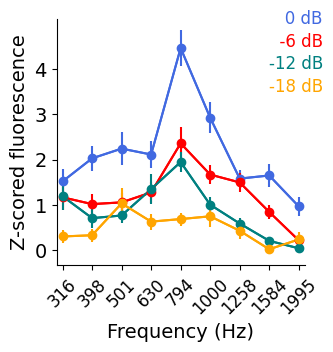

In [62]:
plot_data = matopen(drv*"loudness/plot_data.mat","r")
peak_sem = read(plot_data,"peak_sem")
per_fish_data = read(plot_data,"peakdata_fish")

figure(figsize=(3.2,3.2))
ax = subplot(111)

cols = ["royalblue","red","teal","orange"]
avgs = zeros((10))

for l = 1:4
    col = cols[l]
    for f = 2:10
        avg = mean(vec(per_fish_data[l,:,f]),dims=1)
        avgs[f] = avg[1]
        scatter(f,avg,color=col,zorder=3)
        if f < 10
            next_avg = mean(vec(per_fish_data[l,:,f+1]),dims=1)
            plot([f,f+1],[avg,next_avg],color=col)
        end
    end
    errorbar(collect(2:10), avgs[2:10], 
end

text(9,5,"   0 dB",color=cols[1],fontsize=12)
text(9,4.5,"  -6 dB",color=cols[2],fontsize=12)
text(9,4,"-12 dB",color=cols[3],fontsize=12)
text(9,3.5,"-18 dB",color=cols[4],fontsize=12)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ylabel("Z-scored fluorescence",fontsize=fs)
xticks(collect(2:10),[316,398,501,630,794,1000,1258,1584,1995],rotation = 45,fontsize=10)
xlabel("Frequency (Hz)",fontsize=fs)

ax.tick_params(axis="x",labelsize=12)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels([0,1,2,3,4],fontsize=fs)
ax.set_xlim(1.8,10.2)
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
#tight_layout()

plt.savefig("figs/Fig2D.svg",dpi=600)

### Mixed model analysis of loudness curve

In [90]:
using MixedModels, StatsModels

LoadError: ArgumentError: Package StatsModels not found in current path:
- Run `import Pkg; Pkg.add("StatsModels")` to install the StatsModels package.


In [104]:
volumes = zeros((648))
frequencies = zeros((648))
ids = zeros((648))
responses = zeros((648))

possible_freqs = [316,398,501,630,794,1000,1258,1584,1995]
possible_vols = [0,-6,-12,-18]
ctr=1
for vol = 1:4
   for freq = 2:10
        for fish = 1:18
            volumes[ctr] = possible_vols[vol]
            frequencies[ctr] = possible_freqs[freq-1]
            responses[ctr] = per_fish_data[vol,fish,freq]
            ids[ctr] = fish
            ctr+=1
        end
    end
end

ids = string.(ids)

loudness_df = DataFrame()
loudness_df[!,"volume"] = volumes
loudness_df[!,"frequencies"] = frequencies
loudness_df[!,"ids"] = ids
loudness_df[!,"responses"] = responses

In [124]:
fm = @formula(responses~1+volume+frequencies+ volume&frequencies + (1 + volume + frequencies | ids))
fm1 = fit(MixedModel, fm, loudness_df)

|                      |    Est. |     SE |     z |      p |  σ_ids |
|:-------------------- | -------:| ------:| -----:| ------:| ------:|
| (Intercept)          |  2.5798 | 0.2688 |  9.60 | <1e-21 | 0.9649 |
| volume               |  0.1029 | 0.0129 |  8.00 | <1e-14 | 0.0066 |
| frequencies          | -0.0006 | 0.0002 | -2.79 | 0.0052 | 0.0008 |
| volume & frequencies | -0.0000 | 0.0000 | -1.18 | 0.2362 |        |
| Residual             |  1.0841 |        |       |        |        |


In [145]:
OneSampleTTest(per_fish_data[2,:,9],per_fish_data[2,:,6])

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -1.51496
    95% confidence interval: (-2.302, -0.7275)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0008

Details:
    number of observations:   18
    t-statistic:              -4.059120178298211
    degrees of freedom:       17
    empirical standard error: 0.37322265224229745


## Figure 2E

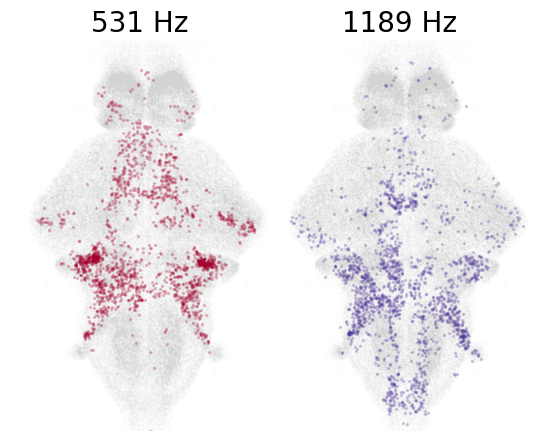

In [369]:
figure(figsize=(5.5,4.5)); 
a = 0.2

titles = ["531 Hz","1189 Hz"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]

s = 2

ax1 = subplot(121);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=s,alpha=a)

ax2 = subplot(122);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=s,alpha=a)

ctr = 1
for ax in [ax1,ax2]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=20)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2F.png",dpi=600)

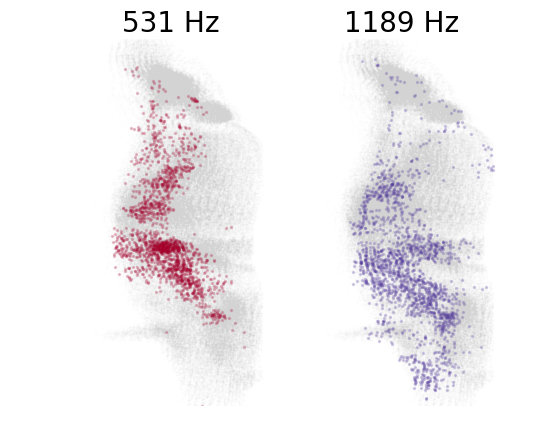

In [592]:
figure(figsize=(5.5,4.5)); 
a = 0.2

titles = ["531 Hz","1189 Hz"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]

s = 2

ax1 = subplot(121);
scatter(centroids[nr2,3],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,3],centroids[sr2,1],color=colors[3],s=s,alpha=a)

ax2 = subplot(122);
scatter(centroids[nr3,3],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,3],centroids[sr3,1],color=colors[4],s=s,alpha=a)

ctr = 1
for ax in [ax1,ax2]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,150)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=20)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

#plt.savefig("figs/Fig2F.png",dpi=600)

## Figure 2G

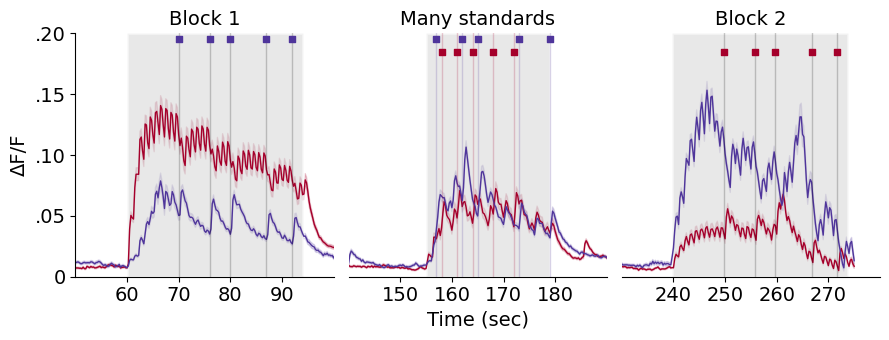

In [370]:
figure(figsize=(9,3.5))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

stim_adj = 0.002
ymax = 0.2
x = collect(1:n_frames)./fps
axes = [ax1,ax2,ax3]

for t = 1:3
    ctr = 3
    subplot(1,3,t)
    for r in [5,6]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        fill_between(x, avg.-stdev, avg.+stdev,color=colors[ctr],alpha=0.2)
        plot(x,avg,color=colors[ctr],linewidth=1)
        ctr+=1
    end
end

yticks = collect(0:0.05:ymax)
yticklabels = ["0",".05",".10",".15",".20"]
ob_size = 20 
ob_offset = 0.005

set_axes(ax1,ax2,ax3,yticks,yticklabels)
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
tight_layout()

plt.savefig("figs/Fig2G.svg",dpi=300)

## Figure 2F motor

Need to run motion analysis first (below)

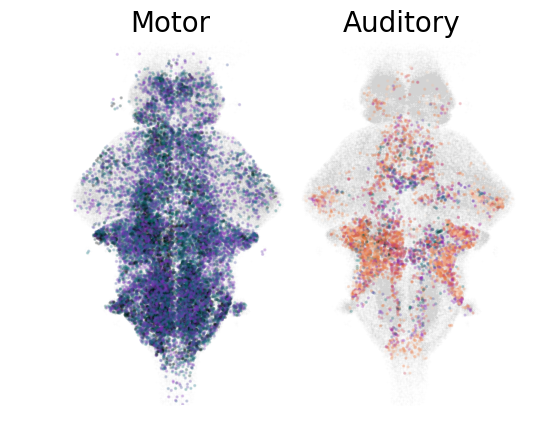

In [74]:
figure(figsize=(5.5,4.5))

cm = cool_cmap
vm = 0.5
s = 2
ax1 = subplot(121); axis("off"); title("Motor",fontsize=20)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot[sig_mot],s=s,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

ax2 = subplot(122); axis("off"); title("Auditory",fontsize=20)
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=s,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

for ax in [ax1,ax2]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig("figs/Fig2F.png",dpi=300)

# Figure 3

## Figure 3A

In [371]:
function decay_plot(s,st)
    c2 = 1
    ctr = 1
    totals = zeros((n_fish,length(st)))
    totals_pre = zeros((n_fish,length(st)))
    avgs = zeros(length(st))
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[s,:][1]
        sr = intersect(sr,valid_idx)
        avgs = zeros(length(st))
        c2 = 0
        for stim in st
            roi_avgs = []
            for roi in sr
                y = (DF[roi,stim:stim+isi])
                y = y[2:end] .- y[1]
                avg = maximum(y)
                if isfinite(avg) == true
                    push!(roi_avgs,avg)
                end
            end
            c2 +=1
            if length(roi_avgs) > 0
                avg = nnmean(roi_avgs)
            else
                avg = NaN
            end
            avgs[c2] = avg
            totals[ctr,c2] = avg
        end
        ctr+=1
    end
    avg = vec(nnmean(totals,1))
    #avg = avg .- avg[1]
    errs = vec(nnstd(totals,1))./n_fish
    return avg,errs
end

nnmean(x) = mean(filter(!isnan,x))
nnmean(x,y) = mapslices(nnmean,x,dims=y)

nnstd(x) = std(filter(!isnan,x))
nnstd(x,y) = mapslices(nnstd,x,dims=y)

decay_plot (generic function with 1 method)

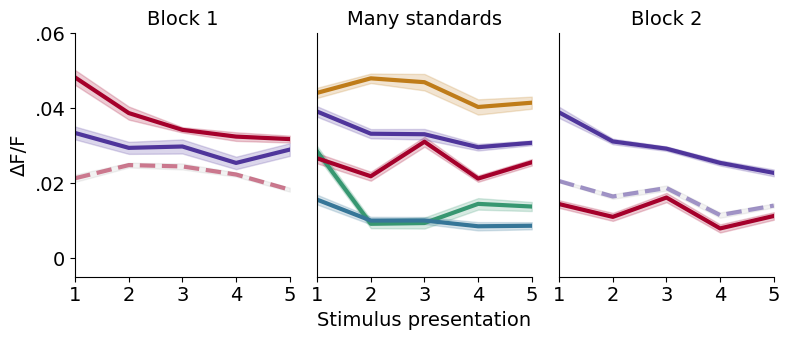

In [374]:
figure(figsize=(8,3.5))
x = collect(1:5)

s = 1

ax1 = subplot(131); title("Block 1",fontsize=fs)
start = block_edges[1,1]
avg, stdev = decay_plot(s,oddball_1st.-isi)
plot(x,avg,color=colors[3],linewidth=3,linestyle="dashed",alpha=0.5)
fill_between(x, avg.-stdev, avg.+stdev,color="gray",alpha=0.1)

avg, stdev = decay_plot(s,oddball_1st)
plot(x,avg,color=colors[4],linewidth=3)
fill_between(x, avg.-stdev, avg.+stdev,color=colors[4],alpha=0.2)

start = block_edges[1,1]#+isi*3
avg, stdev = decay_plot(s,collect(start:isi:start+isi*5)[1:end-1])
plot(x,avg,color=colors[3],linewidth=3)
fill_between(x, avg.-stdev, avg.+stdev,color=colors[3],alpha=0.2)

ax2 = subplot(132); title("Many standards",fontsize=fs)
col2 = [[55,151,113]./255,colors[3],[191,124,25]./255,colors[4],[54,118,152]./255]
ctr = 1
for times in [ms_f3_times,ms_f1_times,ms_f4_times,ms_f2_times,ms_f5_times]
    avg, stdev = decay_plot(s,times)
    plot(x,avg,color=col2[ctr],linewidth=3)
    fill_between(x, avg.-stdev, avg.+stdev,color=col2[ctr],alpha=0.2)
    ctr+=1
end

ax3 = subplot(133); title("Block 2",fontsize=fs)
start = block_edges[1,1]
avg, stdev = decay_plot(s,oddball_2nd.-isi)
plot(x,avg,color=colors[4],linewidth=3,alpha=0.5,linestyle="dashed")
fill_between(x, avg.-stdev, avg.+stdev,color="gray",alpha=0.1)

avg, stdev = decay_plot(s,oddball_2nd)
plot(x,avg,color=colors[3],linewidth=3)
fill_between(x, avg.-stdev, avg.+stdev,color=colors[3],alpha=0.2)

start = block_edges[3,1]#+isi*3
avg, stdev = decay_plot(s,collect(start:isi:start+isi*5)[1:end-1])
plot(x,avg,color=colors[4],linewidth=3)
fill_between(x, avg.-stdev, avg.+stdev,color=colors[4],alpha=0.2)

for ax in [ax1,ax2,ax3]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="x",labelsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(x,fontsize=14)
    ax.set_ylim(-0.005,0.06)
    ax.set_xlim(1,5)
end
    
for ax in [ax2,ax3]
    ax.set_yticks([])
    ax.set_yticks([], minor=true)
end

ax1.set_ylabel("ΔF/F",fontsize=fs)
ax1.set_yticks([0,0.02,0.04,0.06])
ax1.set_yticklabels(["0",".02",".04",".06"],fontsize=14)

ax2.set_xlabel("Stimulus presentation",fontsize=fs)
tight_layout()

plt.savefig("figs/Fig3A.svg",dpi=300)

## Figure 3B

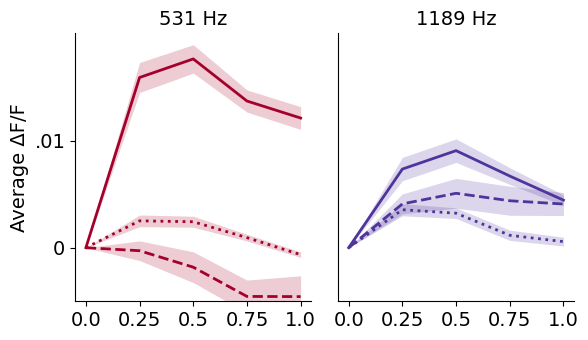

606060606060

In [389]:
figure(figsize=(6,3.5))

ax1 = subplot(121)
ax2 = subplot(122)

start = block_edges[1,1]
refs1 = collect(start:isi:start+isi*5)[1:end-1]
start = block_edges[3,1]
refs2 = collect(start:isi:start+isi*5)[1:end-1]

st_ctr = 1
s = 1

plot_colors = ["black","grey","grey","black","grey","grey"]
plot_colors = [colors[3],colors[3],colors[3],colors[4],colors[4],colors[4]]
avgs = zeros((n_fish,5))
color_ctr = 1
x = collect(0:1:4)

for sts in [[refs1,oddball_2nd,oddball_2nd.-isi],[refs2,oddball_1st,oddball_1st.-isi]]
    subplot(1,2,st_ctr)
    avgs = zeros((n_fish,5,5))
    spot_ctr = 1; 
    for st in sts
        fc = 1
        avgs = zeros((n_fish,5))
        curr_n = 0
        for fish in unique(idx_fish)
            valid_idx = findall(idx_fish[1,:] .== fish)
            sr = sig_rois[spot_ctr+4,:][1]
            sr = intersect(sr,valid_idx)
            for stim in st
                y = vec(nnmean(DF[sr,stim:stim+isi+1],1))
                y = y[2:end].-y[1]
                y = y.-y[1]
                avgs[fc,:] .+= y
                curr_n += 1
            end
            fc+=1
        end

        y = vec(nnmean(avgs[:,:],1))/n_fish
        err = vec(nnstd(avgs[:,:],1))/curr_n
        
        linestyle = "solid"
        if spot_ctr == 2
            linestyle = "dashed"
        elseif spot_ctr == 3
            linestyle = "dotted"
        end
        
        fill_between(x, y.-err, y.+err,color=plot_colors[color_ctr],alpha=0.2,linewidth=0)

        plot(x,y,linestyle=linestyle,color=plot_colors[color_ctr],linewidth=2)
        spot_ctr += 1
        color_ctr += 1
    end
    st_ctr += 1
end
    
titles = ["531 Hz","1189 Hz"]
ctr=1
for ax in [ax1,ax2]
    ax.set_title(titles[ctr],fontsize=fs)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_ylim(-0.005,0.02)
    ax.set_xticks(collect(0:1:4))
    ax.set_xticklabels(collect(0:1:4)./fps,fontsize=14)
    ctr+=1
end

for ax in [ax2,ax3]
    ax.set_yticks([])
    ax.set_yticks([], minor=true)
end

ax1.set_ylabel("Average ΔF/F",fontsize=fs)
ax1.set_yticks([0,0.01])
ax1.set_yticklabels(["0",".01"],fontsize=14)

tight_layout()
plt.savefig("figs/Fig3B.svg",dpi=600)

# Figure 4

## Figure 4B

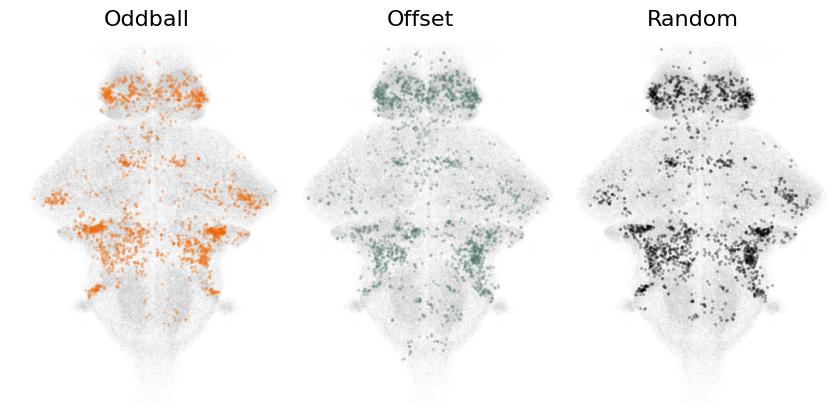

In [83]:
figure(figsize=(8.5,4.25)); 
a = 0.2

fs = 16

titles = ["Oddball","Offset","Random"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[3,:][1]
sr2 = sig_rois[3,:][1]
nr3 = nonsig_rois[4,:][1]
sr3 = sig_rois[4,:][1]

s = 2
nsa = 0.002

ax1 = subplot(131); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=s,alpha=a)

ax2 = subplot(132); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=s,alpha=a)

ax3 = subplot(133); 
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color="black",s=s,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr],fontsize=fs)
    ctr+=1
end

tight_layout()
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)

savefig("figs/Fig4B.png",dpi=600)

## Figure 4C

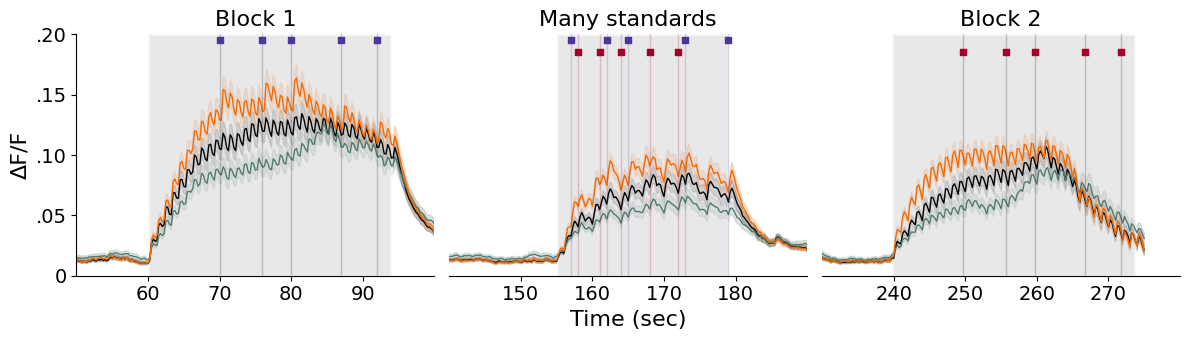

In [85]:
figure(figsize=(12,3.5))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

#ymax = 0.2
stim_adj = 0.002

for t = 1:3
ctr = 1

axes = [ax1,ax2,ax3]
x = collect(1:n_frames)./fps
c2 = reverse([colors[1],colors[2],"black"])
subplot(1,3,t)
    for r in [4,3,2]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        fill_between(x, avg.-stdev, avg.+stdev,color=c2[ctr],alpha=0.2)
        plot(x,avg,color=c2[ctr],linewidth=1)
        ctr+=1
    end

end

ymax = 0.2
yticks = collect(0:0.05:ymax)
yticklabels = ["0",".05",".10",".15",".20"]
ob_size = 20 
ob_offset = 0.005

set_axes(ax1,ax2,ax3,yticks,yticklabels)
for ax = [ax1,ax2,ax3]
ax.set_ylim(0,0.2)
end
PyPlot.plt.subplots_adjust(wspace=0,hspace=0)
tight_layout()

plt.savefig("figs/Fig4C.svg",dpi=300)

# Supplemental Figure 1

## Figure S1C + D

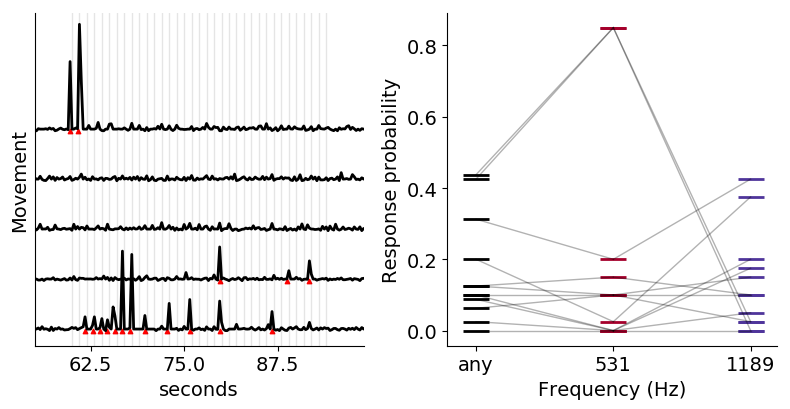

In [283]:
i = 7
ctr = 0
rows,cols = 1,2
figure(figsize=(cols*4,rows*4.2))

ax1 = subplot(rows,cols,1)
ax1.set_yticks([])
for s in stimtimes
    axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end
ylabel("Movement",fontsize=fs)
xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

ax2 = subplot(rows,cols,2)
ylabel("Response probability",fontsize=fs)
xticks([1,2,3],["any","531","1189"],fontsize=14)
xlabel("Frequency (Hz)",fontsize=fs)

i =1
for i = 1:n_fish
    total_stim, responses, f1_resp, f2_resp = 0,0,0,0

    subplot(rows,cols,1)
    signal = diff(motion_reg[i][:])
    signal[signal.<-0.001] .= 0
    if i < 6
        plot(signal.+ctr,color="black",linewidth=2)
    end
    for s in vcat(f1_times,f2_times)
        total_stim += 1
        segment = signal[s-1:s+2]
        if maximum(segment) > 0.005
            responses += 1
            idx = findall(segment .== maximum(segment))[1]
            if i < 6
                scatter(s-1,-0.001.+ctr,color="red",marker="^",s=10,alpha=1)
            end
            
            if s in f1_times
                f1_resp += 1
            end
            if s in f2_times
                f2_resp += 1
            end
            
        end
    end
    ctr+=0.03

    subplot(rows,cols,2)
    scatter(1,responses/total_stim,color="black",marker="_",s=350,linewidth=2)
    scatter(2,f1_resp/40,color=colors[3],marker="_",s=350,linewidth=2)
    scatter(3,f2_resp/40,color=colors[4],marker="_",s=350,linewidth=2)
    
    plot([1,2],[responses/total_stim,f1_resp/40],color="black",linewidth=1,alpha=0.3)
    plot([2,3],[f1_resp/40,f2_resp/40],color="black",linewidth=1,alpha=0.3)

end

for ax in [ax1,ax2]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

ax1.set_xticks([250,300,350])
ax1.set_xticklabels([250,300,350]./fps,fontsize=14)
ax1.set_xlabel("seconds",fontsize=fs)
ax1.set_ylim(-0.01,0.19)

ax2.set_yticks([0,0.2,0.4,0.6,0.8])
ax2.set_yticklabels([0,0.2,0.4,0.6,0.8],fontsize=14)


tight_layout()

savefig("figs/FigS1CD.svg",dpi=600)

## Figure S1E

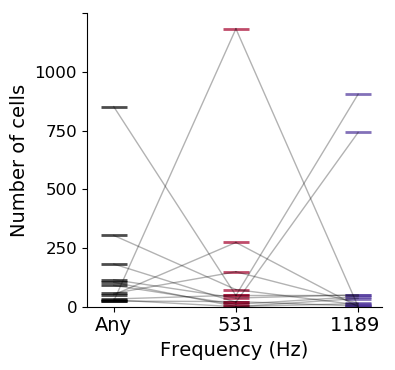

In [298]:
i = 7
ctr = 0
rows,cols = 1,2
figure(figsize=(cols*3.6,rows*3.8))

ax1 = subplot(rows,cols,1)
ylabel("Number of cells",fontsize=fs)
xticks([1,2,3],["Any","531","1189 "],fontsize=14)
xlabel("Frequency (Hz)",fontsize=fs)

i =1
for i = 1:n_fish
    fish_idx = findall(reset_idx_fish[1,:] .== i)
    sr = sig_rois[1,:][1]
    idx1 = length(intersect(sr,fish_idx))#/length(fish_idx)
    scatter(1,idx1,color="black",marker="_",s=350,linewidth=2,alpha=0.7)
    
    sr = sig_rois[5,:][1]
    idx2 = length(intersect(sr,fish_idx))#/length(fish_idx)
    scatter(2,idx2,color=colors[3],marker="_",s=350,linewidth=2,alpha=0.7)
    
    sr = sig_rois[6,:][1]
    idx3 = length(intersect(sr,fish_idx))#/length(fish_idx)
    scatter(3,idx3,color=colors[4],marker="_",s=350,linewidth=2,alpha=0.7)

    
    plot([1,2],[idx1,idx2],color="black",linewidth=1,alpha=0.3)
    plot([2,3],[idx2,idx3],color="black",linewidth=1,alpha=0.3)

end

for ax in [ax1,ax2]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end



ax1.set_yticks([0,250,500,750,1000,1250])
ax1.set_yticklabels([0,250,500,750,1000,""],fontsize=12)


tight_layout()
ylim(0,1250)
savefig("figs/FigS1E.svg",dpi=600)

# Supplemental Figure 2

## Figure S2E

Run motion analysis first

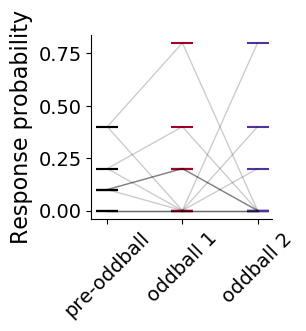

In [93]:
i = 7
ctr = 0
rows,cols = 1,1
figure(figsize=(cols*3,rows*3.2))


ax = subplot(111)
ylabel("Response probability",fontsize=fs)
xticks([1,2,3],["pre-oddball","oddball 1","oddball 2"],rotation=45,fontsize=14)

reference_stim = vcat(oddball_times,ms_f1_times,ms_f2_times)

pre_all = []
f1_all = []
f2_all = []

ob1_resp = zeros(n_fish,length(oddball_1st))
ob2_resp = zeros(n_fish,length(oddball_2nd))

for i = 1:n_fish
    total_stim, responses, f1_resp, f2_resp = 0,0,0,0
    subplot(rows,cols,1)
    signal = diff(motion_reg[i][:])
    signal[signal.<-0.001] .= 0
    ob1_n = 0
    ob2_n = 0
    for s in vcat(oddball_1st,oddball_2nd)#stimtimes[1:end-1]
        segment = signal[s-1:s+2]
        sp = s - isi
        pre_segment = signal[sp-1:sp+2]
        total_stim +=1 
        if s in oddball_1st 
            ob1_n +=1 
        end
        if s in oddball_2nd 
            ob2_n +=1 
        end
        if maximum(segment) > 0.005
            idx = findall(segment .== maximum(segment))[1]
            responses += 1
            if s in oddball_1st
                f1_resp += 1
                ob1_resp[i,ob1_n] = 1
            end
            if s in oddball_2nd
                f2_resp += 1
                ob2_resp[i,ob2_n] = 1
            end     
        end
    end
    ctr+=0.05

    f1_resp = f1_resp/5
    f2_resp = f2_resp/5
    responses = responses/total_stim
    
    push!(pre_all,responses)
    push!(f1_all,f1_resp)
    push!(f2_all,f2_resp)
        
    scatter(1,responses,color="black",marker="_",s=250)
    scatter(2,f1_resp,color=colors[3],marker="_",s=250)
    scatter(3,f2_resp,color=colors[4],marker="_",s=250)
    
    plot([1,2],[responses,f1_resp],color="black",linewidth=1,alpha=0.2)
    plot([2,3],[f1_resp,f2_resp],color="black",linewidth=1,alpha=0.2)
end

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.tick_params(axis="x",labelsize=14)
ax.tick_params(axis="y",labelsize=14)

tight_layout()

savefig("figs/FigS2E.svg",dpi=300)

## Motion analysis

### Reset fish indices

In [68]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

### Regressor for block-specific motions

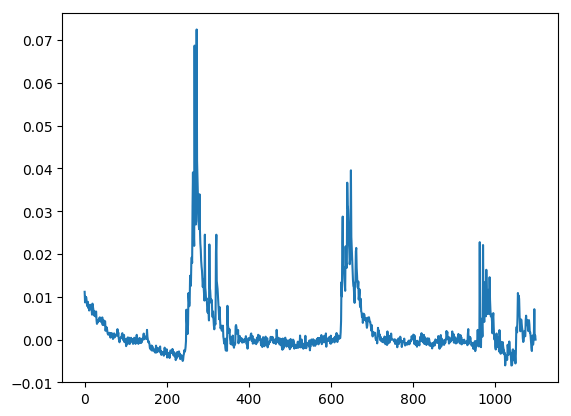

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fab423b71d0>

In [69]:
plot(motion_reg[1][:])

In [70]:
mot_1_reg = zeros(n_fish,length(motion_reg[1][:]))
mot_2_reg = zeros(n_fish,length(motion_reg[1][:]))
for i = 1:n_fish
    for stim in oddball_1st
        mot_1_reg[i,stim-1:stim+isi] = motion_reg[i][stim-1:stim+isi]
    end
    
    for stim in oddball_2nd
        mot_2_reg[i,stim-1:stim+isi] = motion_reg[i][stim-1:stim+isi]
    end
end

In [71]:
coeffs_mot = Array{Float32}(undef,total_rois); fill!(coeffs_mot,NaN)
r2s_mot = Array{Float32}(undef,total_rois); fill!(r2s_mot,NaN)
pvals_mot = Array{Float32}(undef,total_rois); fill!(pvals_mot,NaN)

t = now()
print("starting $t ...")
for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = motion_reg[f][:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot[i] = r2(ols)
        coeffs_mot[i] = coef(ols)[2]
        pvals_mot[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

coeffs_mot1 = Array{Float32}(undef,total_rois); fill!(coeffs_mot1,NaN)
r2s_mot1 = Array{Float32}(undef,total_rois); fill!(r2s_mot1,NaN)
pvals_mot1 = Array{Float32}(undef,total_rois); fill!(pvals_mot1,NaN)

t = now()
print("starting $t ...")
for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = mot_1_reg[f,:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot1[i] = r2(ols)
        coeffs_mot1[i] = coef(ols)[2]
        pvals_mot1[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

coeffs_mot2 = Array{Float32}(undef,total_rois); fill!(coeffs_mot2,NaN)
r2s_mot2 = Array{Float32}(undef,total_rois); fill!(r2s_mot2,NaN)
pvals_mot2 = Array{Float32}(undef,total_rois); fill!(pvals_mot2,NaN)

for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = mot_2_reg[f,:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot2[i] = r2(ols)
        coeffs_mot2[i] = coef(ols)[2]
        pvals_mot2[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

starting 2024-03-23T14:20:37.815 ......complete 2024-03-23T14:20:57.087starting 2024-03-23T14:20:57.089 ......complete 2024-03-23T14:21:15.573...complete 2024-03-23T14:21:34.380

### Compute motion-significant ROIs

In [72]:
pvals_clean = pvals_mot[:]
sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
r2s_clean = replace(r2s_mot[:],NaN=>0)
perc_99 = percentile(r2s_clean,90)
print(perc_99)
sig_roi_r2 = findall(r2s_clean .> perc_99)

sig_mot = intersect(sig_roi_pval,sig_roi_r2)
IJulia.clear_output()

0

In [73]:
figure(figsize=(9,5))

cm = cool
vm = 0.5

subplot(131); axis("off"); title("Motor responsive")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot[sig_mot],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("All auditory")
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("Oddball")
i = vcat(sig_rois[11,:][1],sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/stednitz/.julia/packages/PyCall/L0fLP/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Colormap <PyCall.jlwrap cool> is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r',)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 3378, in scatter
    edgecolors=edgecolors, data=data, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 1718, in inner
    return func(ax, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 4039, in scatter
    collection.set_cmap(cmap)
  File "/usr/lib/python3/dist-packages/matplotlib/cm.py", line 329, in set_cmap
    cmap = get_cmap(cmap)
  File "/usr/lib/python3/dist-packages/matplotlib/cm.py", line 169, in get_cmap
    % (name, ', '.join(sorted(cmap_d))))


In [ ]:
figure(figsize=(9,5))

cm = "bwr"
vm = 0.2
subplot(131); axis("off"); title("Motion")
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=coeffs_mot[sig_mot],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("All auditory")
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot[i],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("All oddball")
i = vcat(sig_rois[11,:][1],sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot[i],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

LoadError: UndefVarError: sig_mot not defined